# Random Forest Classifier in Python

In this notebook you will find the steps to solve a Random Forest classification problem in python. Despite the fact the methodology used in this problem is not original, the example implementation has been created by [Samuel Miravet-Verde](samuel.miravet@crg.eu). Please, link this repository if you are going to use content from it. 

### Loading packages

In [182]:
%matplotlib inline

import numpy as np
from numpy import genfromtxt, savetxt
import seaborn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import StratifiedKFold
from scipy import interp
import matplotlib.pyplot as plt

### Defining datasets

Define the test and training set we are going to use. These datasets has been generated from a real case where we have a binary classifcation problem based on numerical (integer and float) and boolean features. 

In [183]:
#create the training & test sets, skipping the header row with [1:]
dataset = genfromtxt(open('Data/train.csv','r'), delimiter=',', dtype='f8')[1:]    
target = [x[0] for x in dataset]
train = [x[1:] for x in dataset]
test_original = genfromtxt(open('Data/test.csv','r'), delimiter=',', dtype='f8')[1:]
test = [x[1:] for x in test_original]

### Generating a toy model dataset

We are going to generate here a dataset to run a toy model, the specifications of the model include 100 estimators, oob_score on (to have ROC AUC measures) and n_jobs=-1 to work with all the cores available in the local machine.

In [184]:
#create and train the random forest
#multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
rf = RandomForestClassifier(n_estimators=200, oob_score=1, n_jobs = -1, random_state =50, max_features = "auto", min_samples_leaf = 5)

### Classifying

To classify we need to fit the model and after we can estore in two different files the classification problem results:

In [185]:
rf.fit(train, target)

savetxt('Data/classes_predicted.csv', rf.predict(test), delimiter=',', fmt='%f')
savetxt('Data/probabil_predicted.csv', rf.predict_proba(test), delimiter=',', fmt='%f')

### Plot the weights of each feature

One of the advantages we have when we use a Random Forest Classifier is that we work with regression and classification tasks. With the regressions we are able to assign a weight to each feature to know which is the one with more relevance in the decission:

In [186]:
l = ['strand', 'bidirectional', 'stem_len', 'loop_len', 'spacer_len','energy', 'mismatched_b', 'GC', 'Ts', 'ptsc1', 'ptsc2', 'distbef', 'distaft']
importances = rf.feature_importances_


for i in range(0, len(l)):
    print(l[i]+' = '+ str(importances[i]))
    
    
# To plot the weights:
std = np.std([importances for tree in rf.estimators_], axis=0)

strand = 0.000252878730991
bidirectional = 0.00209084692109
stem_len = 0.0415935990095
loop_len = 0.00413492336967
spacer_len = 0.0134745320964
energy = 0.185513986989
mismatched_b = 0.00875155236435
GC = 0.0124428941976
Ts = 0.139030869535
ptsc1 = 0.251339673352
ptsc2 = 0.245242045157
distbef = 0.0945268563706
distaft = 0.00160534190642


In [187]:
indices = np.argsort(importances)[::-1]

In [188]:
print("Feature ranking:")
for f in range(0,len(l)-1):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 9 (0.251340)
2. feature 10 (0.245242)
3. feature 5 (0.185514)
4. feature 8 (0.139031)
5. feature 11 (0.094527)
6. feature 2 (0.041594)
7. feature 4 (0.013475)
8. feature 7 (0.012443)
9. feature 6 (0.008752)
10. feature 3 (0.004135)
11. feature 1 (0.002091)
12. feature 12 (0.001605)


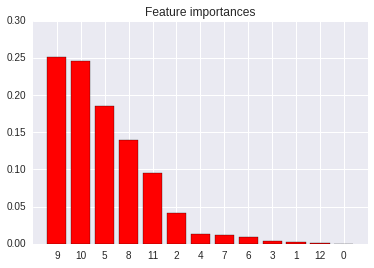

In [189]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(l)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(l)), indices)
plt.xlim([-1, len(l)])
plt.show()

### Check the performance of the model

In [190]:
# model = RandomForestClassifier(n_estimators=200, oob_score=1, n_jobs = -1,random_state =50, max_features = "auto", min_samples_leaf = leaf_size)
rf.fit(train, target)
probs = rf.oob_decision_function_
# Transform to labels
labels = [1.0 if y > x else 0.0 for x, y in probs]

roc_auc_score(target, labels)

0.99137931034482762

### Confusion matrix

First of all prepare the test and training set labels and the predictions performed:

In [178]:
y_test = list(target)
pred = list(labels)

y_train = list([x[0] for x in test_original])
pred_train = list(rf.predict(test))

categories = [0.0, 1.0]

Plot the confusion matrix:

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


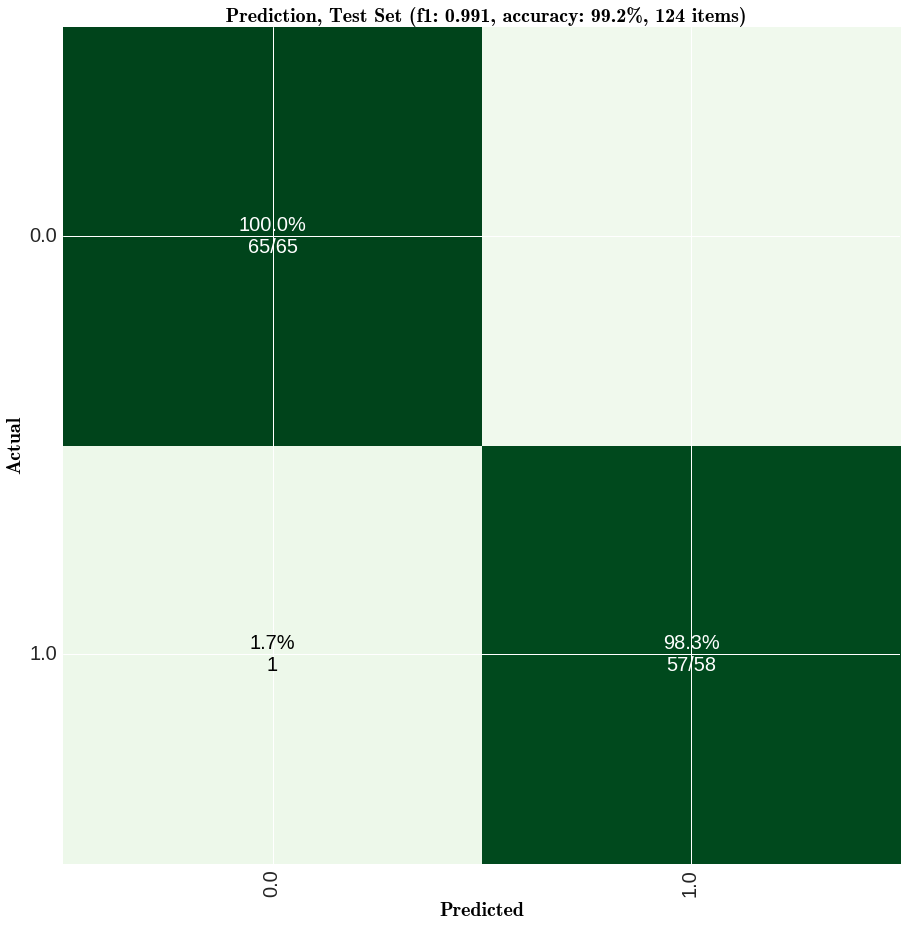

In [179]:
from sklearn import metrics
import numpy as np, pylab as pl
# get overall accuracy and F1 score to print at top of plot
pscore = metrics.accuracy_score(y_test, pred)
score = metrics.f1_score(y_test, pred, average='binary')

# get size of the full label set
dur = len(categories)

# initialize score matrices
trueScores = np.zeros(shape=(dur,dur))
predScores = np.zeros(shape=(dur,dur))

# populate totals
for i in xrange(len(y_test)-1):
    trueIdx = y_test[i]
    predIdx = pred[i]
    trueScores[trueIdx,trueIdx] += 1
    predScores[trueIdx,predIdx] += 1
    
# create %-based results
trueSums = np.sum(trueScores,axis=0)
conf = np.zeros(shape=predScores.shape)
for i in xrange(len(predScores)):
    for j in xrange(dur):
        conf[i,j] = predScores[i,j] / trueSums[i]
    
# plot the confusion matrix
hq = pl.figure(figsize=(15,15));
aq = hq.add_subplot(1,1,1)
aq.set_aspect(1)
res = aq.imshow(conf,cmap=pl.get_cmap('Greens'),interpolation='nearest',vmin=-0.05,vmax=1.)
width = len(conf)
height = len(conf[0])
done = []

# label each grid cell with the misclassification rates
for w in xrange(width):
    for h in xrange(height):
        pval = conf[w][h]
        c = 'k'
        rais = w
        if pval > 0.5: c = 'w'
        if pval > 0.001:
            if w == h:
                aq.annotate("{0:1.1f}%\n{1:1.0f}/{2:1.0f}".format(pval*100.,predScores[w][h],trueSums[w]), xy=(h, w), 
                  horizontalalignment='center',
                  verticalalignment='center',color=c,size=20)
            else:
                aq.annotate("{0:1.1f}%\n{1:1.0f}".format(pval*100.,predScores[w][h]), xy=(h, w), 
                  horizontalalignment='center',
                  verticalalignment='center',color=c,size=20)
        
# label the axes
pl.xticks(range(width), categories[:width],rotation=90,size=20)
pl.yticks(range(height), categories[:height],size=20)

# add a title with the F1 score and accuracy
aq.set_title(" Prediction, Test Set (f1: "+"{0:1.3f}".format(score)+', accuracy: '+'{0:2.1f}%'.format(100*pscore)+", " + str(len(y_test)) + " items)",fontname='Arial',size=20,color='k')
aq.set_ylabel("Actual",fontname='Arial',size=20,color='k')
aq.set_xlabel("Predicted",fontname='Arial',size=20,color='k')
pl.grid(b=True,axis='both')

# save it
# pl.savefig("pred.conf.test.png")

### Plot ROC Curves



In [192]:
fpr, tpr, thresholds = metrics.roc_curve(target, labels, pos_label=1)

array([ 0.98275862,  1.        ])

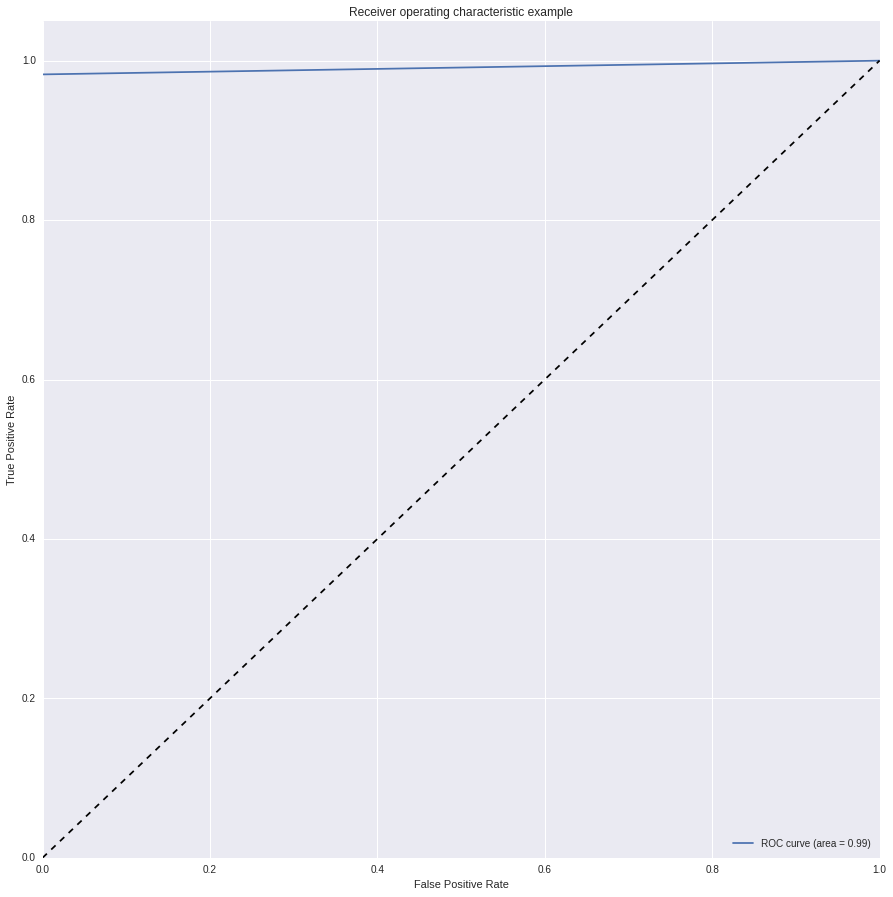

In [199]:
def plotROC(target, labels):

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(set(labels))):
        fpr[i], tpr[i], _ = roc_curve(target, labels)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    ##############################################################################
    # Plot of a ROC curve for a specific class
    plt.figure(figsize=(15,15))
    plt.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
plotROC(target, labels)

### Try several parameters

AUC - ROC :  0.991379310345


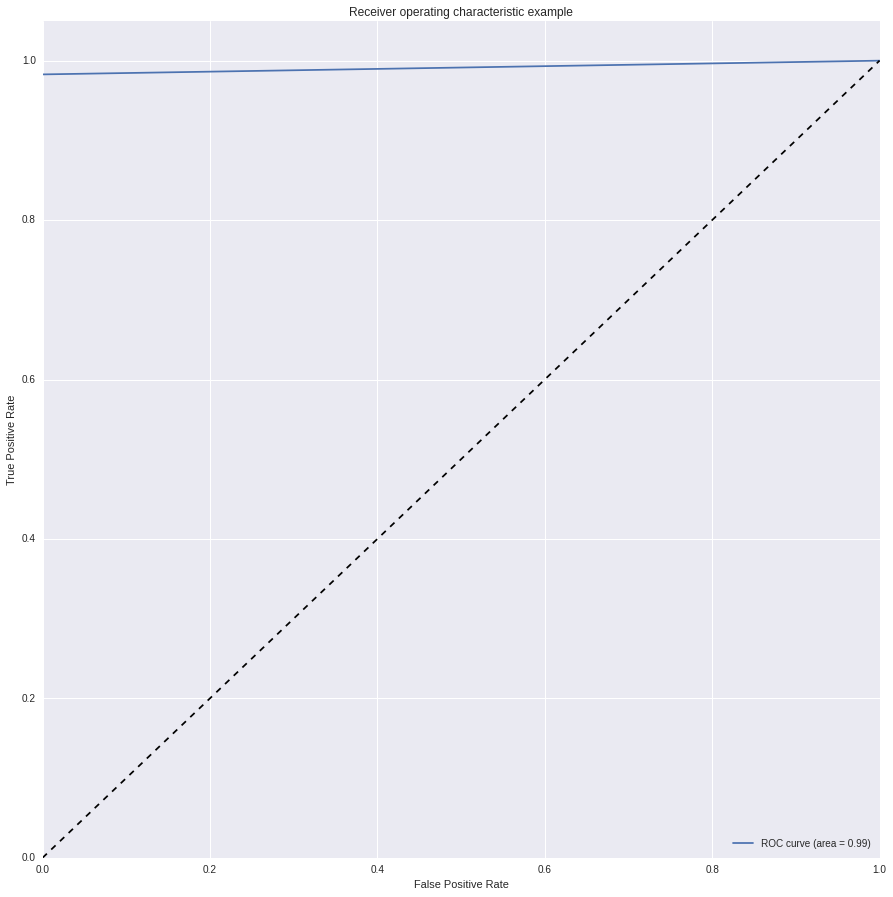

AUC - ROC :  0.991379310345


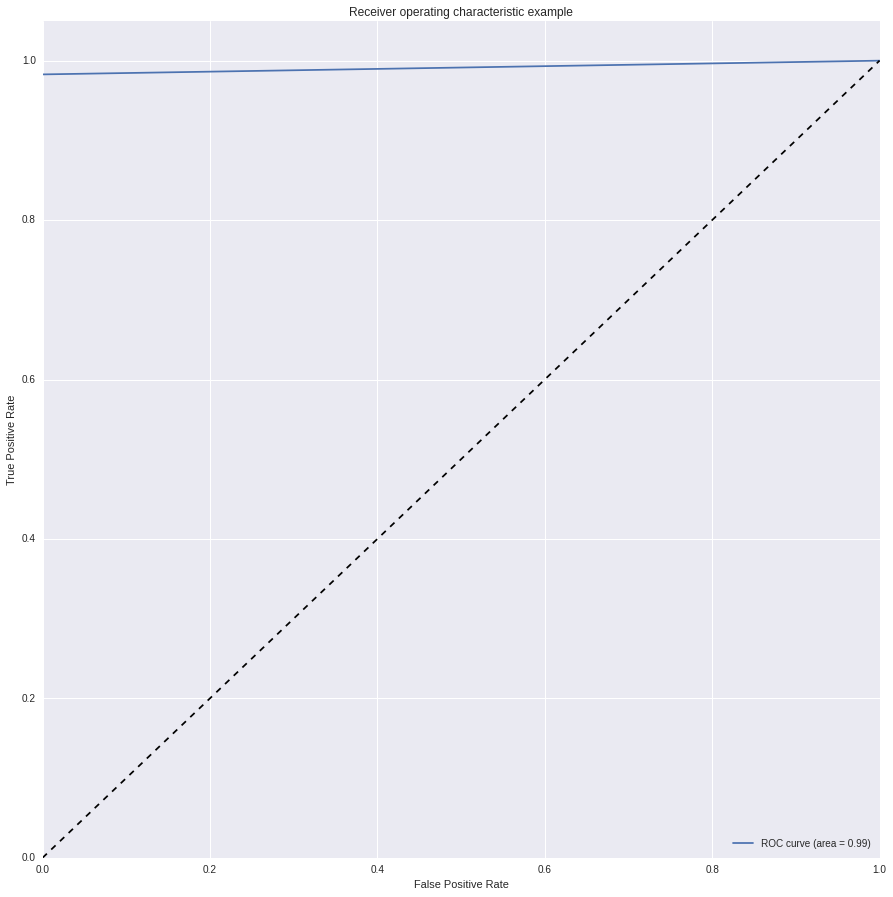

AUC - ROC :  0.98275862069


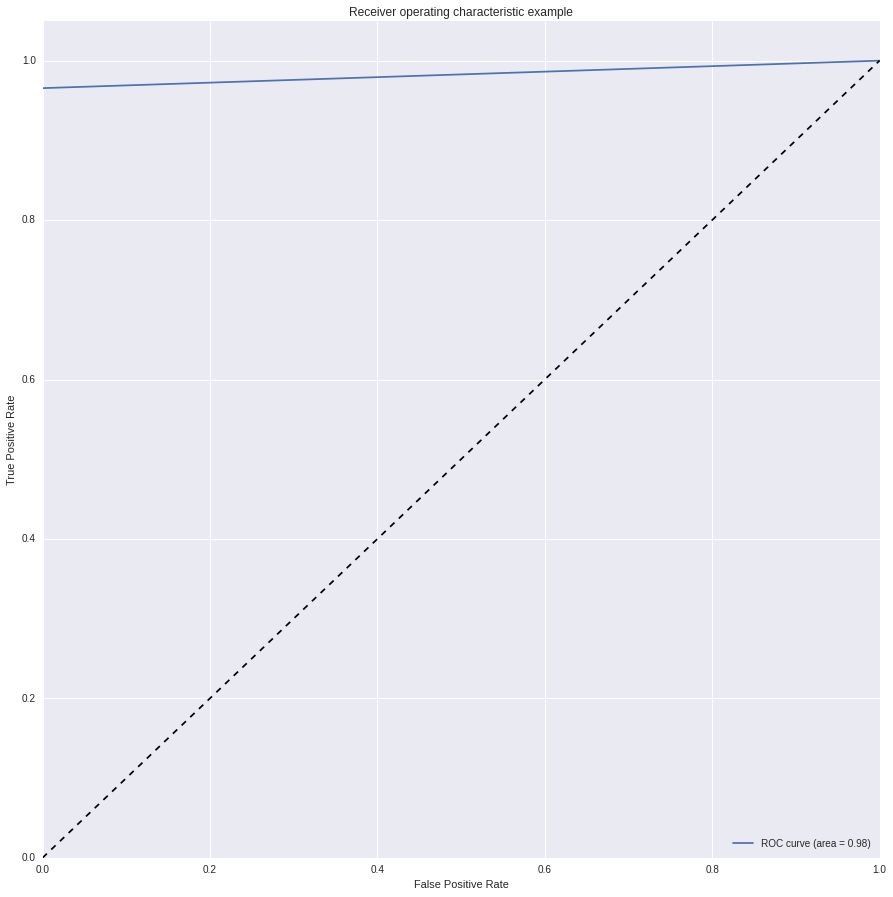

AUC - ROC :  0.5


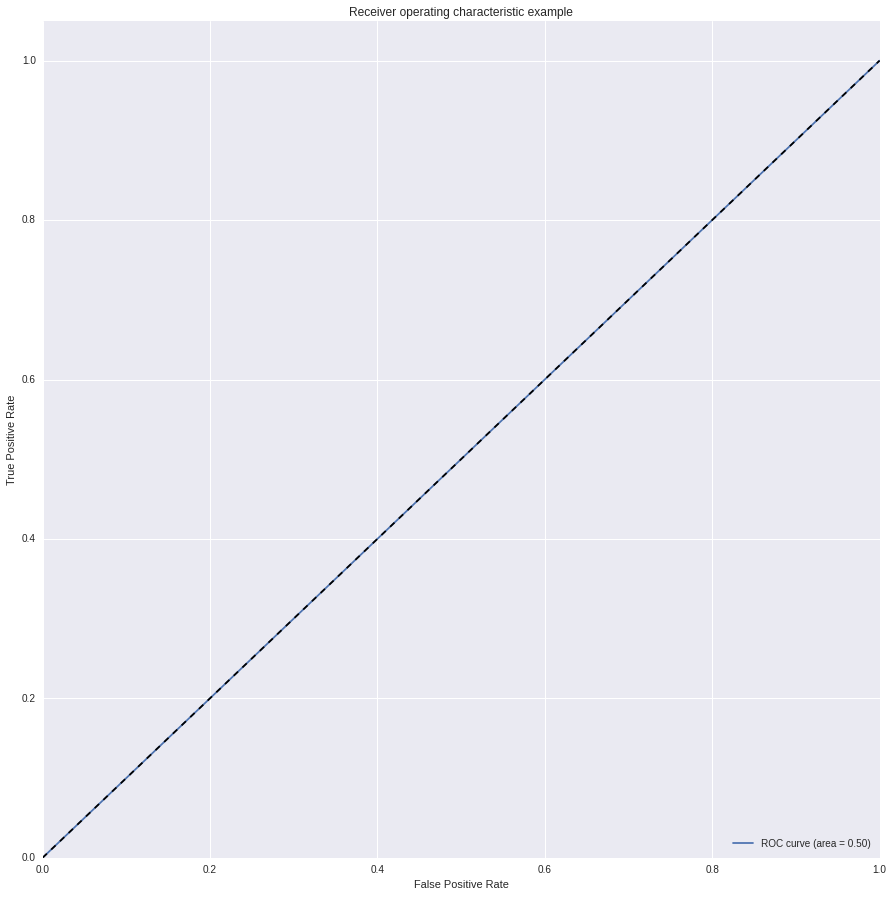

AUC - ROC :  0.5


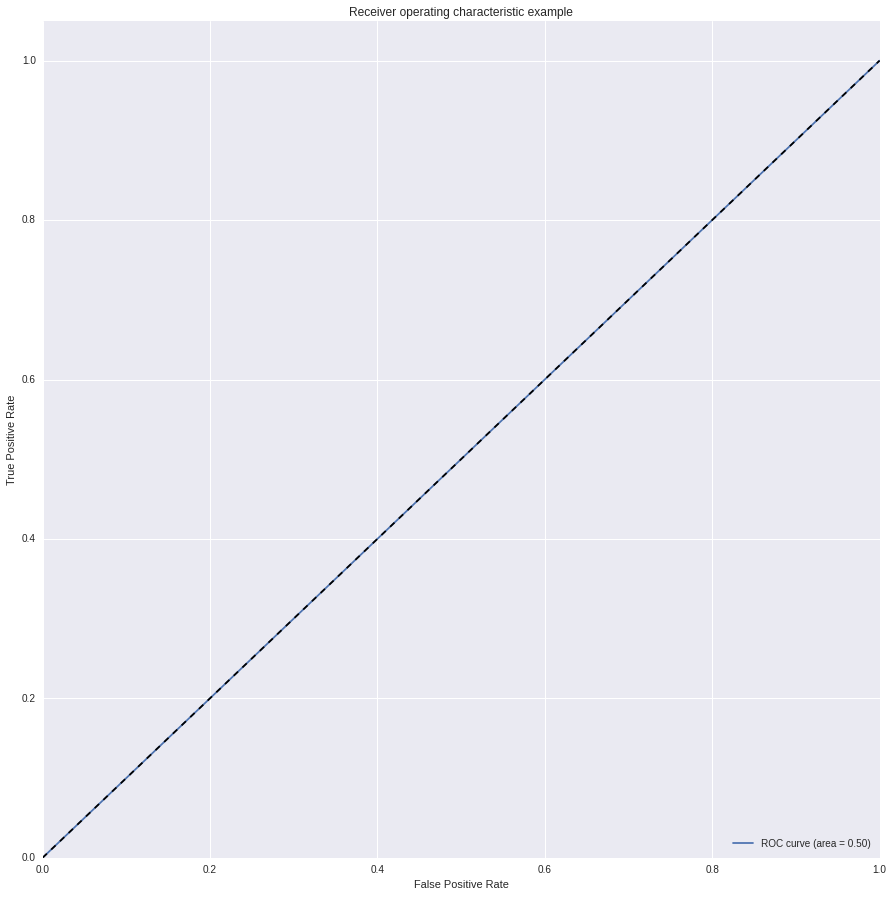

AUC - ROC :  0.5


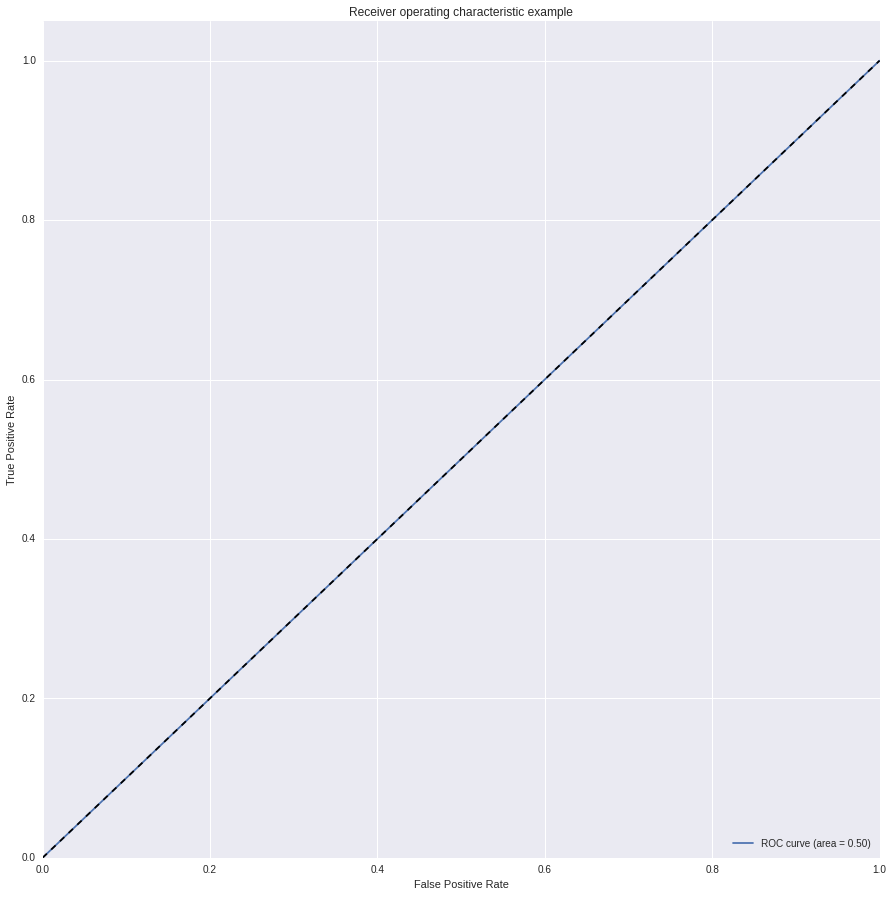

AUC - ROC :  0.5


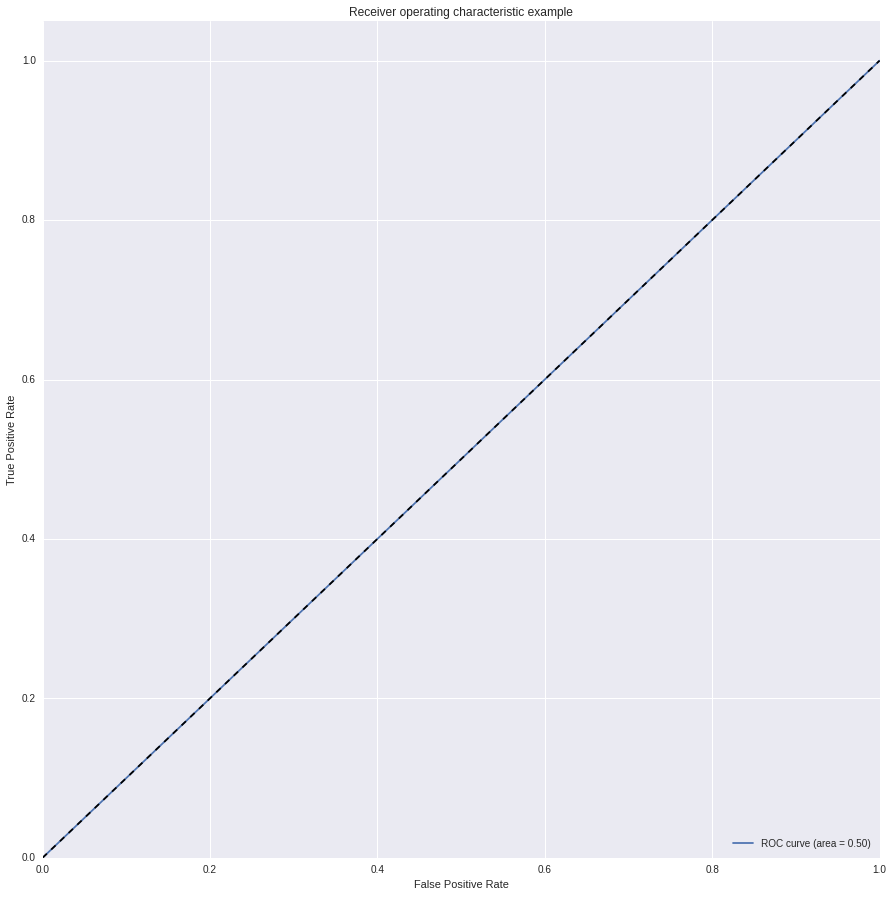

In [202]:
sample_leaf_options = [1,5,10,50,100,200,500]

for leaf_size in sample_leaf_options :
    model = RandomForestClassifier(n_estimators = 200, oob_score=1, n_jobs = -1,random_state =50, max_features = "auto", min_samples_leaf = leaf_size)
    model.fit(train, target)
    probs = model.oob_decision_function_
    # Transform to labels
    labels = [1.0 if y > x else 0 for x, y in probs]
    print "AUC - ROC : ", roc_auc_score(target,labels)
    plotROC(target, labels)